See [fast_wcs_interp_torch_experiments_part2](fast_wcs_interp_torch_experiments_part2.ipynb) for previous part

In [1]:
from pathlib import Path
#import psutil
#import pickle

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import constants

from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler


from jwst import datamodels

%matplotlib inline
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.pipeline import make_pipeline

from sklearn import svm
from sklearn.preprocessing import StandardScaler

# Data loading

In [3]:
slit_name = 's00066'

redux_path = Path(f'data/jwst_outputs/redux_{slit_name}/')

In [4]:
cal_paths = list(redux_path.glob('*cal.fits'))
cal_paths

[PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs2_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs2_cal.fits')]

In [5]:
cal_dms = {p.name: datamodels.open(p) for p in tqdm(cal_paths) if 'jw02609010001_03101_00002_nrs2_cal' in p.name}
cal_dms

  0%|          | 0/4 [00:00<?, ?it/s]

{'jw02609010001_03101_00002_nrs2_cal.fits': <MultiSlitModel from jw02609010001_03101_00002_nrs2_cal.fits>}

In [6]:
slit_all = {}
for k, dm in cal_dms.items():
    matches = np.array([s.source_id for s in dm.slits]) == 42
    assert np.sum(matches)==1
    idx = np.where(matches)[0][0]

    slit_all[k] = dm.slits[idx]

In [7]:
slit = slit_all['jw02609010001_03101_00002_nrs2_cal.fits']

In [8]:
#phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z+0.5/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_model = fits.open('phoenix/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom
phoenix_wave = fits.getdata('phoenix/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')*u.angstrom

phoenix_spec = Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

2024-04-01 20:22:16,376 - stpipe - WARNING - UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard


In [9]:
wls = np.quantile(slit.wavelength[np.isfinite(slit.wavelength)], [0, .5,1])*u.micron

msk = (wls[0] <= phoenix_spec.spectral_axis) & (phoenix_spec.spectral_axis<=wls[-1])

phoenix_sub_spec = Spectrum1D(spectral_axis=phoenix_spec.spectral_axis[msk], 
                                        flux=phoenix_spec.flux[msk])

In [10]:
dmodel = np.diff(phoenix_sub_spec.spectral_axis)

phoenix_lowres_wls_dlamb = np.max(dmodel)*10
phoenix_lowres_wl_bins = np.arange(wls[0].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   wls[-1].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   phoenix_lowres_wls_dlamb.to(phoenix_lowres_wls_dlamb.unit).value)*phoenix_lowres_wls_dlamb.unit

phoenix_lowres = FluxConservingResampler().resample1d(phoenix_sub_spec, 
                            (phoenix_lowres_wl_bins[:-1] + phoenix_lowres_wl_bins[1:])/2)

len(phoenix_lowres.spectral_axis)/slit.data.shape[1]  # tells how much better sampled the "low" res spectrum is from the data

11.77783203125

### Cuda/torch preliminaries

In [11]:
import os
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [12]:
for nm in 'cpu,cuda,cudnn,mps,mkl,mkldnn,openmp'.split(','):
    be = getattr(torch.backends, nm)
    built = be.is_built() if hasattr(be, 'is_built') else None
    avail = be.is_available() if hasattr(be, 'is_available') else None
    if avail is None and nm == 'cuda':
        avail = torch.cuda.is_available()
    print(nm, built, avail) 

torch_device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {torch_device} device")

cpu None None
cuda True True
cudnn None True
mps False False
mkl None True
mkldnn None True
openmp None True
Using cuda device


In [13]:
primary_datatype = torch.float32
def dconvert(x):
    cons = torch.from_numpy if isinstance(x, np.ndarray) else torch.Tensor
    return cons(x).to(torch_device, dtype=primary_datatype)

In [14]:
param_simplers = 'lambda,raoff,decoff'.split(',')
lptp = np.ptp(phoenix_lowres.spectral_axis)
lmin = np.min(phoenix_lowres.spectral_axis)
def ptrans_3feature(urand):
    l = lptp*urand[0] + lmin
    ro = (urand[1]*2 - 1)
    do = (urand[2]*2 - 1)
    
    return l,ro << u.arcsec,do << u.arcsec

base_sc = SkyCoord(slit.source_ra<<u.deg, slit.source_dec<<u.deg)
def make_batch_3feature(rng, batch_size):
    l, ro, do = ptrans_3feature(rng.random(size=(len(param_simplers), batch_size)))
    l0 = l

    sc = base_sc.spherical_offsets_by(ro, do)
    
    outs = np.array(slit.meta.wcs.world_to_pixel(sc, l0))
    ins = np.array([l.value, ro.value, do.value])

    return dconvert(ins).T, dconvert(outs).T

[t.shape for t in make_batch_3feature(np.random.default_rng(), 100)]

[torch.Size([100, 3]), torch.Size([100, 2])]

In [15]:
def make_grid_3feature(sizes, flatten=False):
    mingrids = ptrans_3feature([0 for _ in sizes])
    maxgrids = ptrans_3feature([1 for _ in sizes])
    mgrids = [np.linspace(*e) for e in zip(mingrids, maxgrids, sizes)]
    l, ro, do = np.meshgrid(*mgrids)

    sc = base_sc.spherical_offsets_by(ro, do)
    outs = dconvert(slit.meta.wcs.world_to_pixel(sc, l))

    ins = dconvert((l.value, ro.value, do.value))

    ins = ins.permute(*np.roll(range(len(ins.shape)), -1))
    outs = outs.permute(*np.roll(range(len(outs.shape)), -1))

    if flatten:
        ins = ins.reshape(ins.shape.numel()//ins.shape[-1], ins.shape[-1])
        outs = outs.reshape(outs.shape.numel()//outs.shape[-1], outs.shape[-1])
    
    return ins, outs

valid_ins, valid_outs = make_grid_3feature((100,100,100))
valid_ins_plot, valid_outs_plot = make_grid_3feature((100,10,10), flatten=True)
valid_ins.shape, valid_ins_plot.shape, valid_ins.shape, valid_outs_plot.shape

/tmp/ipykernel_2451/3779681214.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return cons(x).to(torch_device, dtype=primary_datatype)


(torch.Size([100, 100, 100, 3]),
 torch.Size([10000, 3]),
 torch.Size([100, 100, 100, 3]),
 torch.Size([10000, 2]))

# Training Functions

In [132]:
def batch_train_resample(model, batch_size, n_batches, npregen, log_period=500, seed=42, optimizer=None, loss_fcn=None, 
                         valid_ins=valid_ins, valid_outs=valid_outs, perm=True, 
                         lrsched=None, verbose=True):
    """pregen is a number of samples.  must be larger than n_batches, and each batch will sample a random permutation."""
    assert (npregen == 'valid') or (batch_size <= npregen)
    model = model.to(torch_device)
    
    if isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = np.random.default_rng(seed)
        
    if loss_fcn is None:
        loss_fcn = nn.MSELoss()
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters())
    elif isinstance(optimizer, dict):
        optimizer = torch.optim.Adam(model.parameters(), **optimizer)
    if lrsched is not None:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **lrsched)
        llr = 0

    if npregen == 'valid':
        ins = valid_ins.reshape((valid_ins.shape.numel()//valid_ins.shape[-1], valid_ins.shape[-1]))
        outs = valid_outs.reshape((valid_outs.shape.numel()//valid_outs.shape[-1], valid_outs.shape[-1]))
        npregen = ins.shape[0]
    else:
        ins, outs = make_batch_3feature(rng, npregen)
    idxs = np.arange(npregen)
    
    batchi_test = []
    loss_test = []
    lr_update = []
    model.train()
    
    for batchi in tqdm(list(range(n_batches))):
        if perm:
            rng.shuffle(idxs)
            samples = idxs[:batch_size]
        else:
            samples = rng.integers(npregen, size=batch_size)

        samples_t = torch.from_numpy(samples).to(torch_device)
            
        inb = ins[samples_t]
        outb = outs[samples_t]
            
        pred = model(inb)
        loss = loss_fcn(pred, outb)

        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (log_period is not None and (batchi % log_period == 0)) or batchi == (n_batches-1):
            with torch.no_grad():
                model.eval()
                batchi_test.append(batchi)

                loss_test.append(loss_fcn(model(valid_ins), valid_outs).item())
                if verbose:
                    if verbose == 'r':
                        print('\rtest loss at batch', batchi, 'is', loss_test[-1], end='')
                    else:
                        print('test loss at batch', batchi, 'is', loss_test[-1])
                if lrsched is not None:
                    scheduler.step(loss_test[-1])
                    if llr != scheduler.get_last_lr():
                        llr = scheduler.get_last_lr()
                        if verbose == 'r':
                            print('\r' + ' '*80, end='\r')
                        print('lr updated to', llr, 'at', batchi)
                        lr_update.append(batchi)
            model.train()
        
    model.eval()
    model.batchi_test = batchi_test
    model.loss_test = loss_test
    model.lr_update = lr_update
    return model

In [55]:
def plot_model_run(model, points_to_cut=1, valid_ins=valid_ins, valid_outs=valid_outs):
    batchis = model.batchi_test
    losses = model.loss_test
    lr_update = model.lr_update
    
    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.scatter(batchis[points_to_cut:], losses[points_to_cut:])
    ax1.axhline(0, color='k', alpha=.5)
    
    ax2.scatter(batchis[points_to_cut:], losses[points_to_cut:])
    ax2.semilogy()

    for upd in lr_update:
        for ax in (ax1, ax2):
            ax.axvline(upd, c='k', ls=':', lw=1)

    return fig

def plot_model_results(model, X=valid_ins_plot, Y=valid_outs_plot, maxpoints=None, **plotkwargs):
    with torch.no_grad():
        pred = model(X)
        diff = (pred - Y).cpu().detach().numpy()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

    

    if maxpoints is None:
        slc = slice(None)
    else:
        slc = np.random.permutation(valid_outs_flat.shape[0])[:maxpoints]

    p = pred.cpu().detach().numpy()[slc]
    v = Y.cpu().detach().numpy()[slc]

    plotkwargs.setdefault('marker', 'o')
    plotkwargs.setdefault('linewidth', 0)
    plotkwargs.setdefault('markeredgewidth', 0)
    
    
    ax1.plot(p[:, 0], **plotkwargs, label='pred')
    ax1.plot(v[:, 0], **plotkwargs, label='validation')
    ax1.legend(loc=0)
    ax1.set_ylabel('x')
    
    ax2.plot(p[:, 1], **plotkwargs, label='pred')
    ax2.plot(v[:, 1], **plotkwargs, label='validation')
    ax2.legend(loc=0)
    ax2.set_ylabel('y')
        
    ax3.plot(diff[slc], **plotkwargs)
    ax3.set_ylabel('residuals')
    ax3.legend(['x', 'y'], loc=0)
    
    return fig


# NNs

In [138]:
class RescalingNeuralNetwork(nn.Module):
    def __init__(self, inbounds, outbounds, nneurons=[32, 16], endsmooth=False):
        """
        outbounds should be [(d1lower, d1upper), (d2lower, d2upper), etc...]
        """
        super().__init__()
        self.endsmooth = endsmooth
        assert len(nneurons) >= 1

        in_n = len(inbounds)
        self.inscale = dconvert([u-l for l, u in inbounds])
        self.inoffset = dconvert([l for l, u in inbounds])
        
        out_n = len(outbounds)
        self.outscale = dconvert([u-l for l, u in outbounds])
        self.outoffset = dconvert([l for l, u in outbounds])
        

        stack = [nn.Linear(in_n, nneurons[0]),
                 nn.GELU(),
                 ]
        for n1, n2 in zip(nneurons[:-1], nneurons[1:]):
            stack.append(nn.Linear(n1, n2))
            stack.append(nn.GELU())
        
        self.last_linear = nn.Linear(nneurons[-1], out_n)
        stack.append(self.last_linear)
        
        self.stack = nn.Sequential(*[s for s in stack if s is not None])

    @property
    def in_n(self):
        return self.stack[0].in_features

    @property
    def out_n(self):
        return self.last_linear.out_features
        
    def forward(self, x):
        assert x.shape[-1] == self.in_n
        
        leading_dims = x.shape[:-1]
        xflat = x.reshape(x.shape.numel() // self.in_n, self.in_n)
        xflat_rescaled = (xflat - self.inoffset)/self.inscale
        y = self.stack(xflat_rescaled)
        assert y.shape[-1] == self.out_n
        if self.endsmooth:
            y = torch.atan(y)/torch.pi + .5
        return y.reshape(*leading_dims, self.out_n) * self.outscale + self.outoffset

model = RescalingNeuralNetwork([(0,2), (-1, 2), (3,4)], [(0,2), (-1, 2)], endsmooth=True).to(torch_device)
test_batch_in, test_batch_out = make_batch_3feature(np.random.default_rng(), 100)
model(test_batch_in).shape, test_batch_out.shape, test_batch_in.shape

(torch.Size([100, 2]), torch.Size([100, 2]), torch.Size([100, 3]))

In [61]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale), 
                           1024*15, 100000, log_period=500, npregen=1024*2000, perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.3, 'threshold':.001}, verbose=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

lr updated to [0.001] at 0
lr updated to [0.0003] at 16500
lr updated to [8.999999999999999e-05] at 20500
lr updated to [2.6999999999999996e-05] at 28000
lr updated to [8.099999999999999e-06] at 43000
lr updated to [2.4299999999999996e-06] at 62500
CPU times: user 2min 25s, sys: 6.84 s, total: 2min 32s
Wall time: 2min 28s


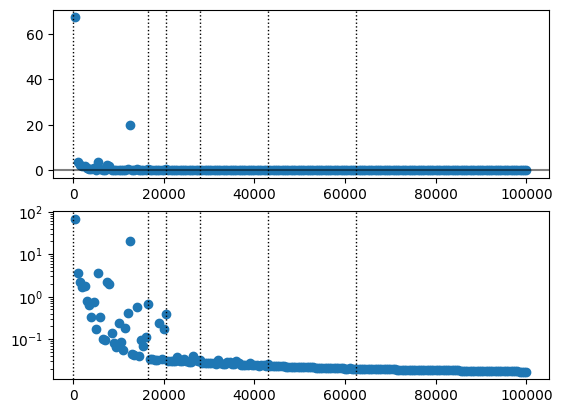

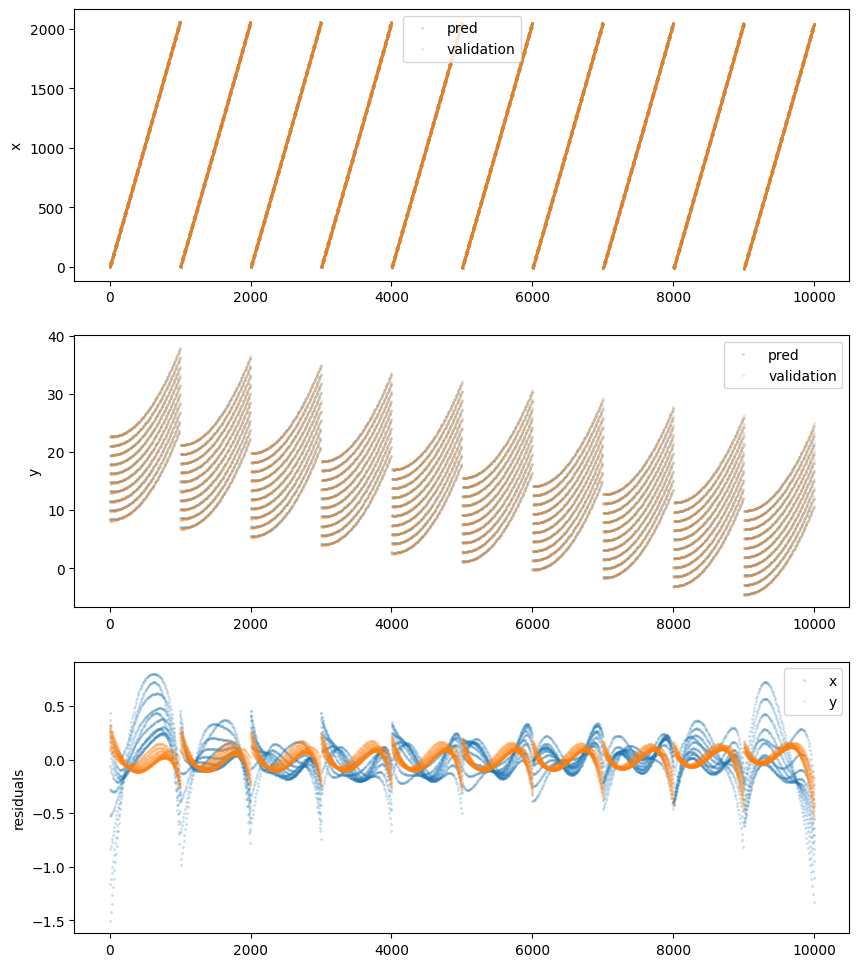

In [62]:
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

More neurons?

In [76]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, first_layer_nneurons=64, inner_layer_nneurons=32), 
                           1024*15, 100000, log_period=250, npregen=1024*200, perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.3, 'threshold':.001}, verbose='r')

  0%|          | 0/100000 [00:00<?, ?it/s]

test loss at batch 0 is 185098.140625
lr updated to [0.001] at 0
test loss at batch 9500 is 0.053795810788869864
lr updated to [0.0003] at 9500
test loss at batch 12750 is 0.036651011556386955
lr updated to [8.999999999999999e-05] at 12750
test loss at batch 17250 is 0.031491011381149294
lr updated to [2.6999999999999996e-05] at 17250
test loss at batch 22250 is 0.024475242942571643
lr updated to [8.099999999999999e-06] at 22250
test loss at batch 51500 is 0.010370661504566674
lr updated to [2.4299999999999996e-06] at 51500
test loss at batch 99999 is 0.005712703801691532CPU times: user 2min 22s, sys: 4.21 s, total: 2min 26s
Wall time: 2min 25s


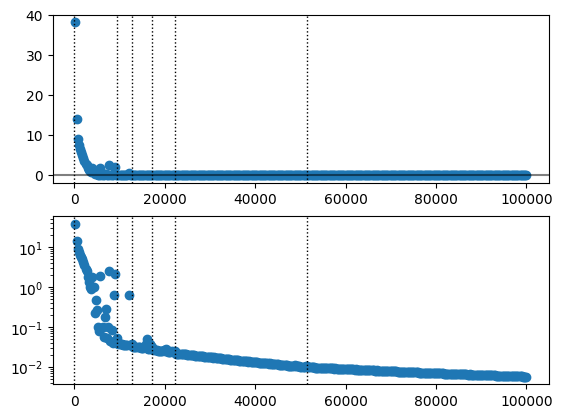

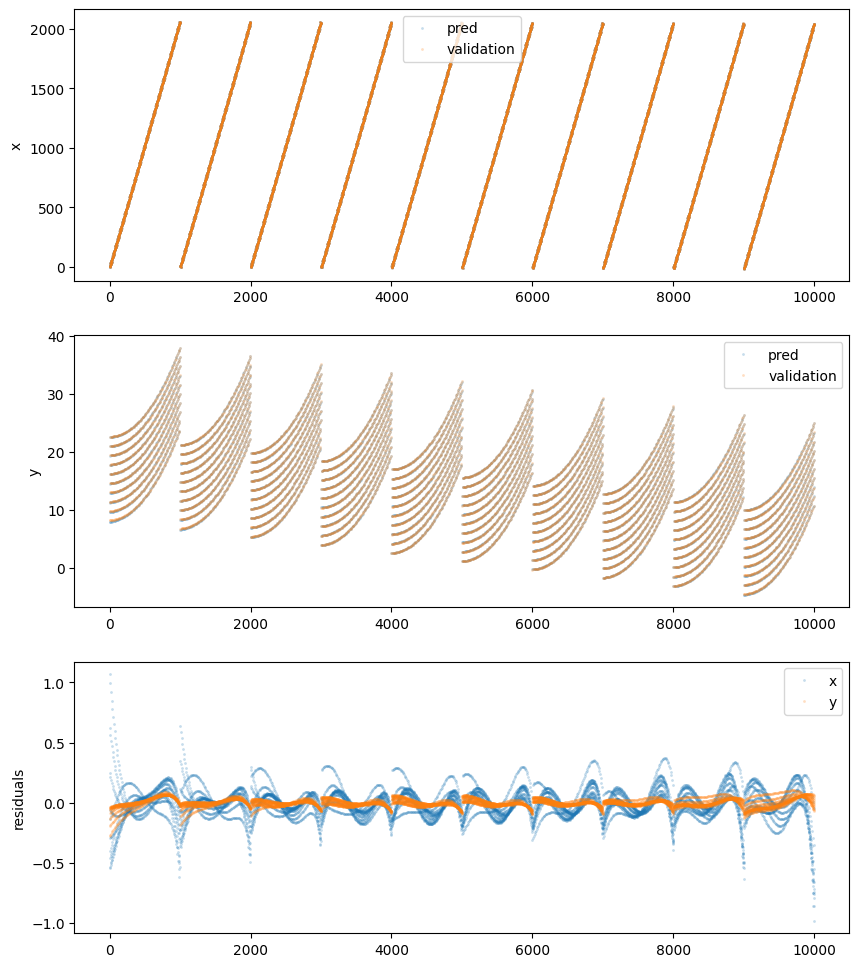

In [77]:
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

Arctan at end?

  0%|          | 0/100000 [00:00<?, ?it/s]

lr updated to [0.001] at 03099.40625                                                                                
lr updated to [0.0005] at 3850025210857391357                                                                                
lr updated to [0.00025] at 4150043369674682617                                                                                
lr updated to [0.000125] at 587502592849731445                                                                                
test loss at batch 99999 is 1.5637987852096558CPU times: user 1min 29s, sys: 2.49 s, total: 1min 32s
Wall time: 1min 30s


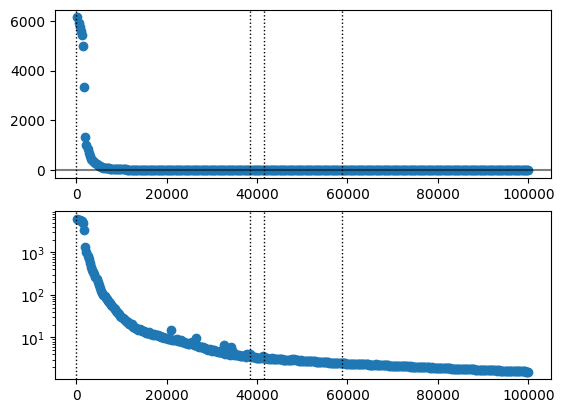

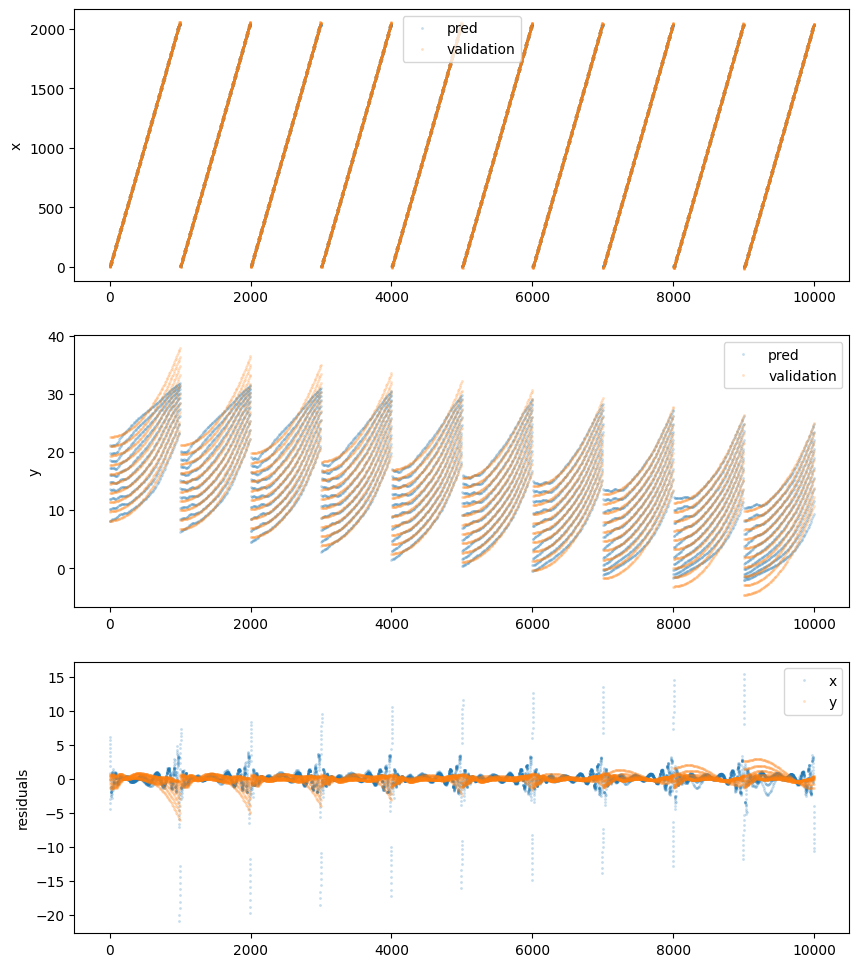

In [100]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, first_layer_nneurons=32, inner_layer_nneurons=16, endsmooth=True), 
                           1024*15, 100000, log_period=250, npregen=1024*200, perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.5, 'threshold':.001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

Maybe the random sampling is messing with things by not reaching into the grid?  Lets intead try batching through the grid.

In [104]:
valid_ins.shape.numel()/valid_ins.shape[-1]/1024

976.5625

  0%|          | 0/100000 [00:00<?, ?it/s]

lr updated to [0.001] at 01369.3125                                                                                
lr updated to [0.0005] at 36000467050552368164                                                                                
lr updated to [0.00025] at 417508596887588501                                                                                
lr updated to [0.000125] at 737506716232299805                                                                                
test loss at batch 99999 is 1.1276156902313232CPU times: user 2min 37s, sys: 3.3 s, total: 2min 41s
Wall time: 2min 41s


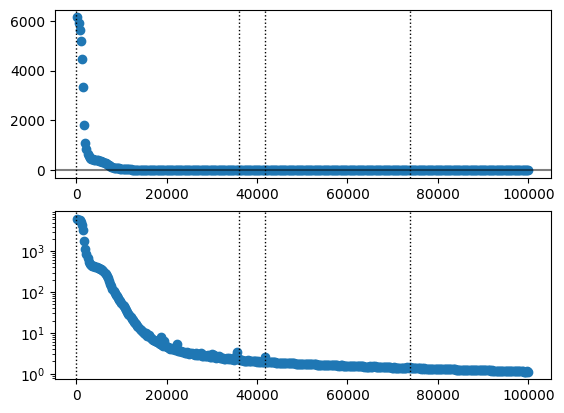

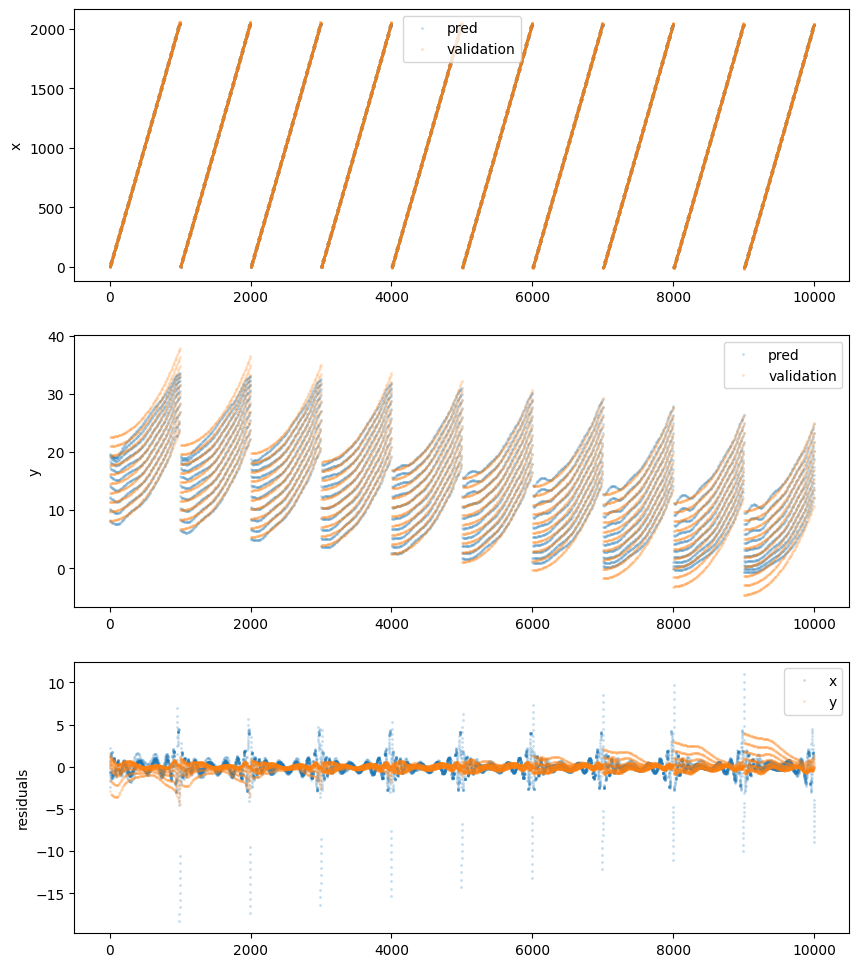

In [119]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, first_layer_nneurons=32, inner_layer_nneurons=16, endsmooth=True), 
                           1024*25, 100000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':3, 'factor':.5, 'threshold':.001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/100000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0005] at 22000                                                 
lr updated to [0.00025] at 27250                                                
lr updated to [0.000125] at 32500                                               
lr updated to [6.25e-05] at 37750                                               
lr updated to [3.125e-05] at 46750                                              
lr updated to [1.5625e-05] at 59500                                             
lr updated to [7.8125e-06] at 91250                                             
test loss at batch 99999 is 0.0032599885016679764CPU times: user 2min 42s, sys: 2.99 s, total: 2min 45s
Wall time: 2min 44s


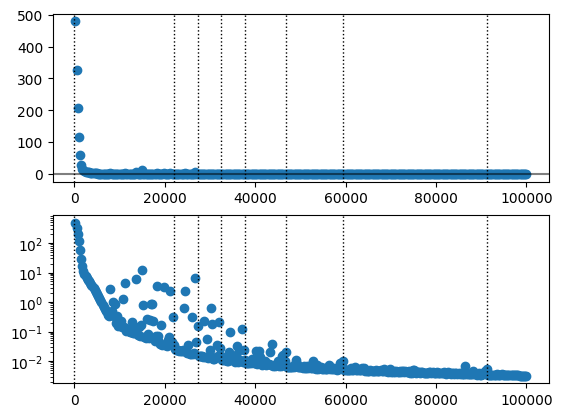

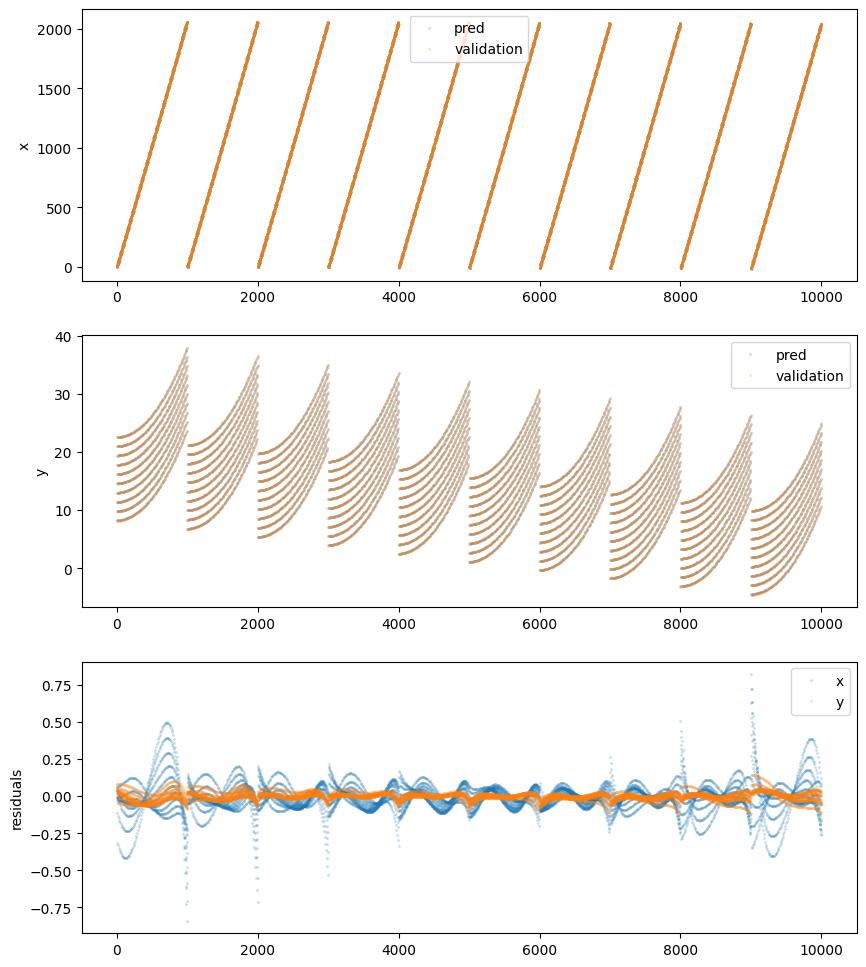

In [135]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, first_layer_nneurons=32, inner_layer_nneurons=16, endsmooth=False), 
                           1024*50, 100000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':5, 'factor':.5, 'threshold':.001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/1000000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0005] at 12500                                                 
lr updated to [0.00025] at 21500                                                
lr updated to [0.000125] at 27000                                               
lr updated to [6.25e-05] at 29750                                               
lr updated to [3.125e-05] at 33250                                              
lr updated to [1.5625e-05] at 40500                                             
lr updated to [7.8125e-06] at 70500                                             
lr updated to [3.90625e-06] at 137250                                           
lr updated to [1.953125e-06] at 177500                                          
lr updated to [9.765625e-07] at 259250                                          
lr updated to [4.8828125e-07] at 452000                                         
lr updated to [2.44140625e-0

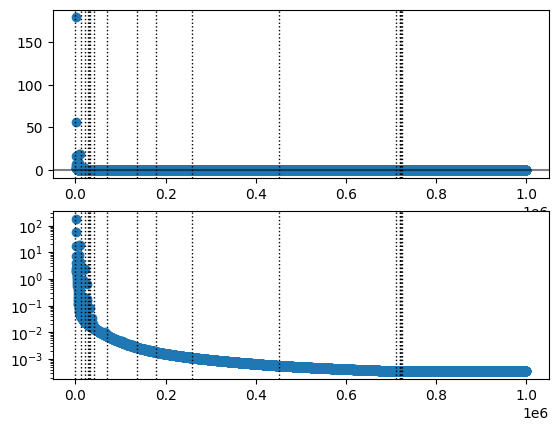

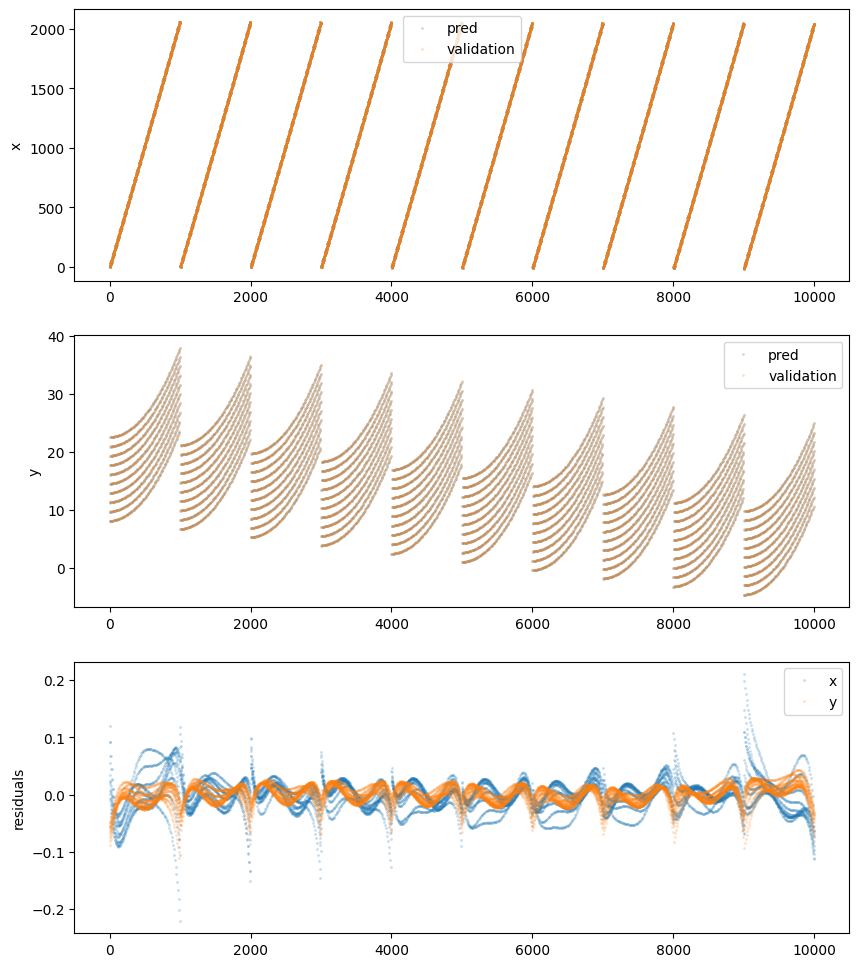

In [137]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[128,32], endsmooth=False), 
                           1024*50, 1000000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':5, 'factor':.5, 'threshold':.001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

Try varying depth but small batches

  0%|          | 0/250000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0005] at 15000                                                 
lr updated to [0.00025] at 27000                                                
lr updated to [0.000125] at 33000                                               
lr updated to [6.25e-05] at 43250                                               
lr updated to [3.125e-05] at 47500                                              
lr updated to [1.5625e-05] at 61500                                             
lr updated to [7.8125e-06] at 76000                                             
lr updated to [3.90625e-06] at 80750                                            
lr updated to [1.953125e-06] at 97000                                           
lr updated to [9.765625e-07] at 99750                                           
lr updated to [4.8828125e-07] at 102250                                         
lr updated to [2.44140625e-0

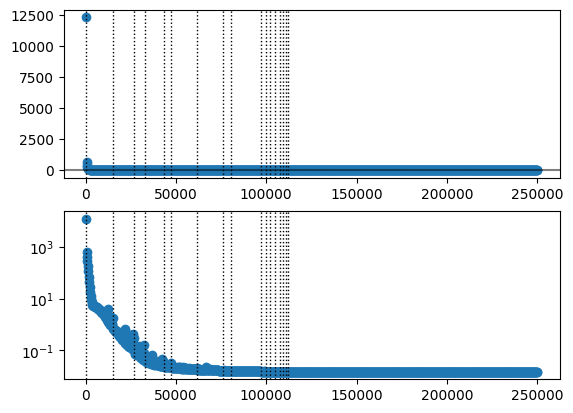

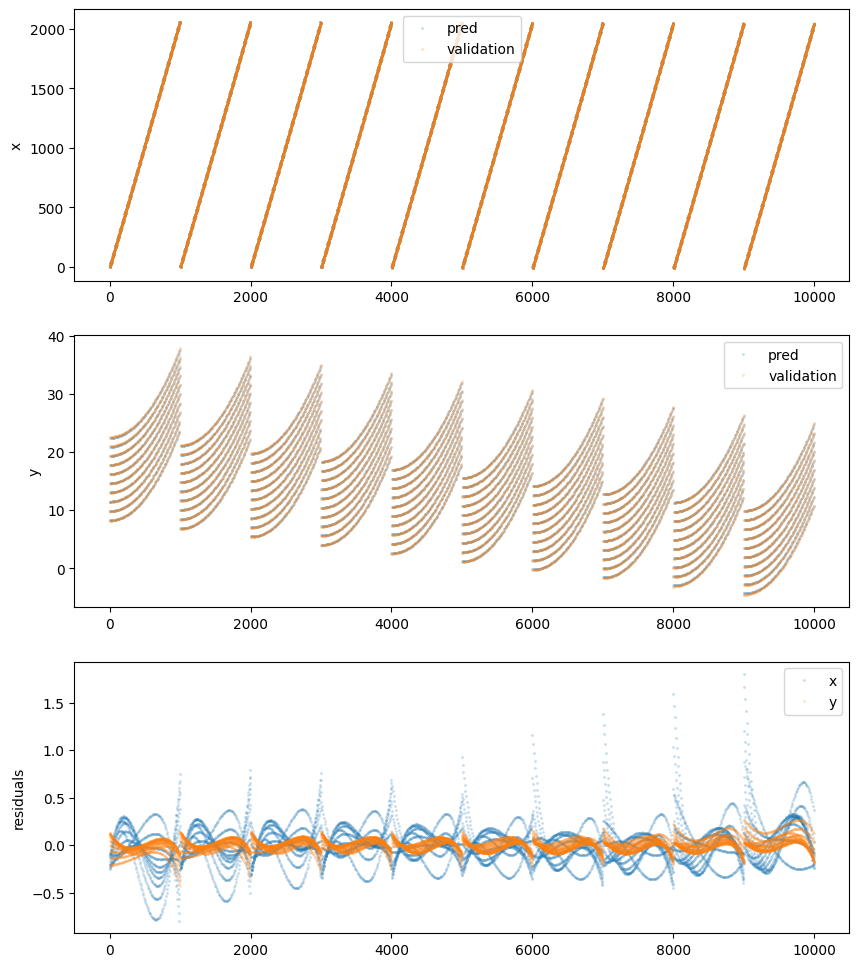

In [141]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[32], endsmooth=False), 
                           1024, 250000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':5, 'factor':.5, 'threshold':.001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/250000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0002] at 23000                                                 
lr updated to [4e-05] at 47500                                                  
lr updated to [8.000000000000001e-06] at 100000                                 
lr updated to [1.6000000000000004e-06] at 117750                                
lr updated to [3.200000000000001e-07] at 139250                                 
lr updated to [6.400000000000003e-08] at 219000                                 
lr updated to [1.2800000000000007e-08] at 222500                                
lr updated to [2.5600000000000015e-09] at 225750                                
test loss at batch 249999 is 0.008469172753393652CPU times: user 3min 49s, sys: 4.59 s, total: 3min 54s
Wall time: 3min 55s


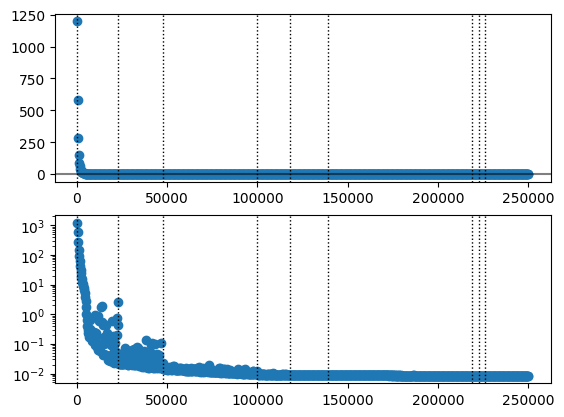

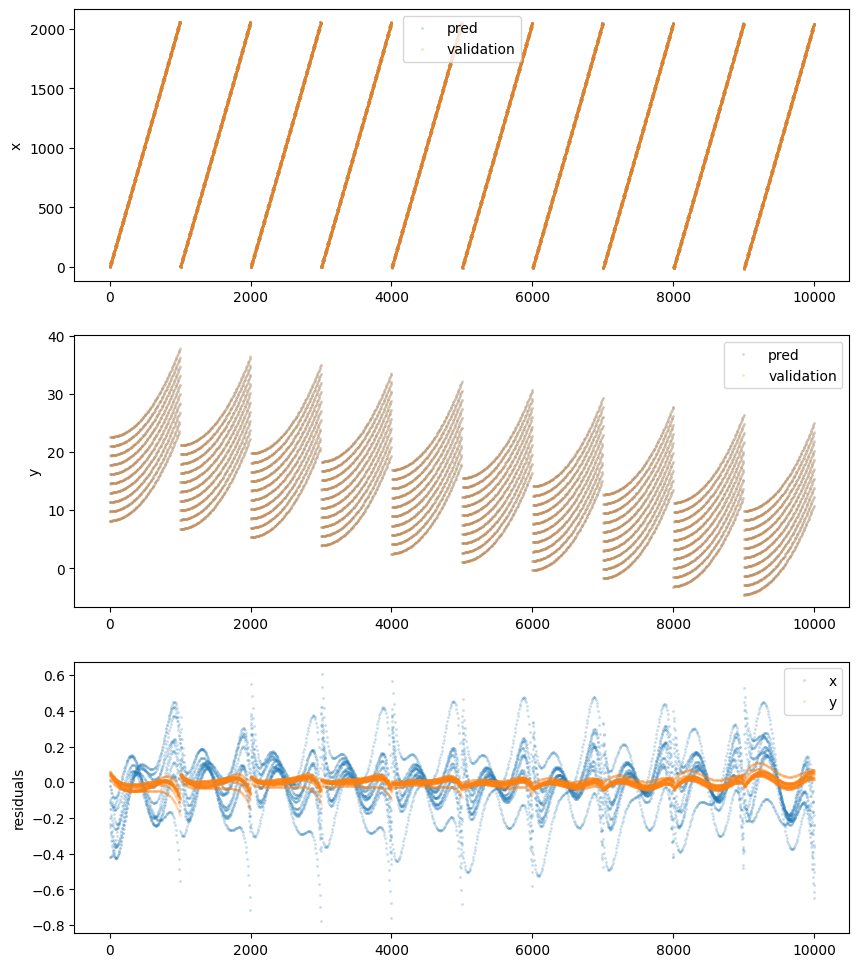

In [144]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[32,16], endsmooth=False), 
                           1024, 250000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':10, 'factor':.2, 'threshold':.0001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/250000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0003] at 15750                                                 
lr updated to [8.999999999999999e-05] at 43500                                  
lr updated to [2.6999999999999996e-05] at 48000                                 
lr updated to [8.099999999999999e-06] at 120500                                 
lr updated to [2.4299999999999996e-06] at 159500                                
lr updated to [7.289999999999998e-07] at 193500                                 
lr updated to [2.1869999999999994e-07] at 234000                                
test loss at batch 249999 is 0.006657023448497057CPU times: user 5min 39s, sys: 7.15 s, total: 5min 46s
Wall time: 5min 49s


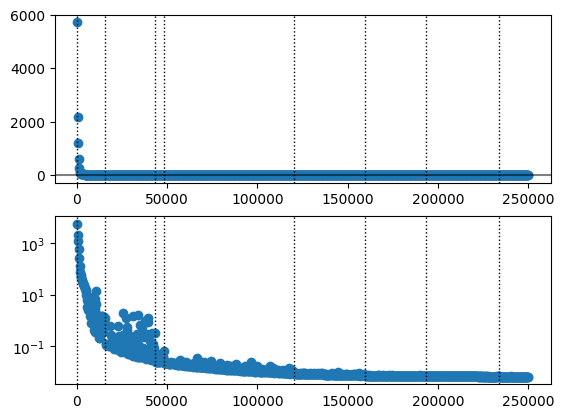

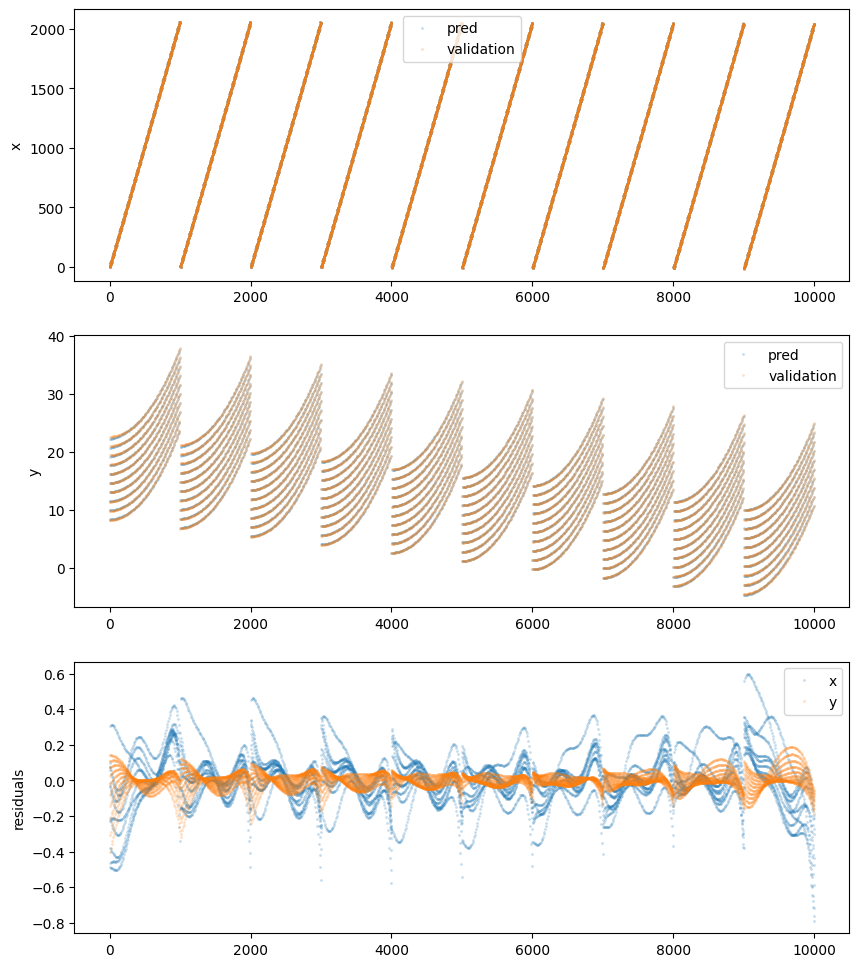

In [145]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[16,16,16,16], endsmooth=False), 
                           1024, 250000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':10, 'factor':.3, 'threshold':.0001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/250000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0003] at 24250                                                 
lr updated to [8.999999999999999e-05] at 47250                                  
lr updated to [2.6999999999999996e-05] at 67750                                 
lr updated to [8.099999999999999e-06] at 82500                                  
lr updated to [2.4299999999999996e-06] at 179250                                
test loss at batch 249999 is 0.0011556537356227636CPU times: user 6min 11s, sys: 6.44 s, total: 6min 17s
Wall time: 6min 18s


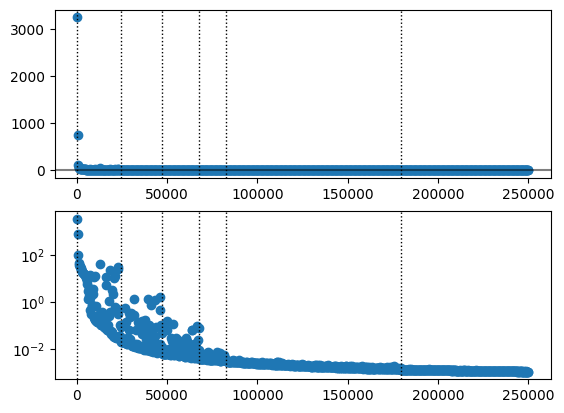

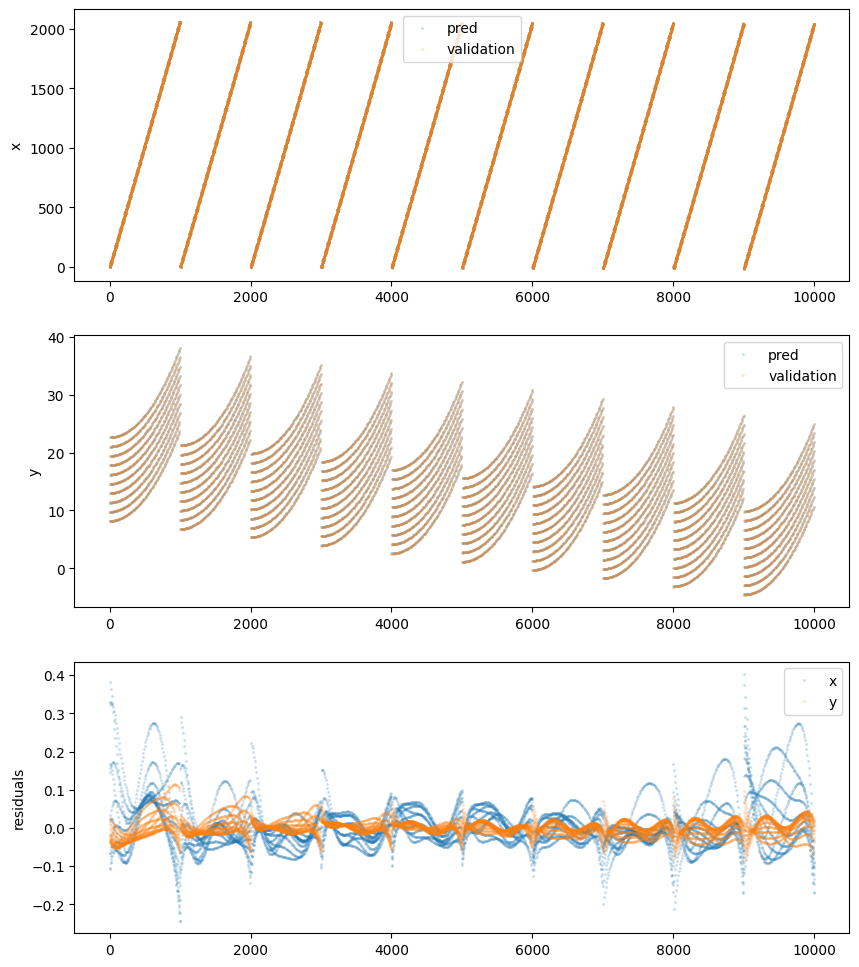

In [146]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[16,16,16,16], endsmooth=False), 
                           1024*16, 250000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':10, 'factor':.3, 'threshold':.0001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)

  0%|          | 0/250000 [00:00<?, ?it/s]

lr updated to [0.001] at 0                                                      
lr updated to [0.0003] at 27750                                                 
lr updated to [8.999999999999999e-05] at 55750                                  
lr updated to [2.6999999999999996e-05] at 60500                                 
lr updated to [8.099999999999999e-06] at 65500                                  
lr updated to [2.4299999999999996e-06] at 112500                                
lr updated to [7.289999999999998e-07] at 178750                                 
test loss at batch 249999 is 0.000583556538913399CPU times: user 6min 19s, sys: 6.72 s, total: 6min 26s
Wall time: 6min 27s


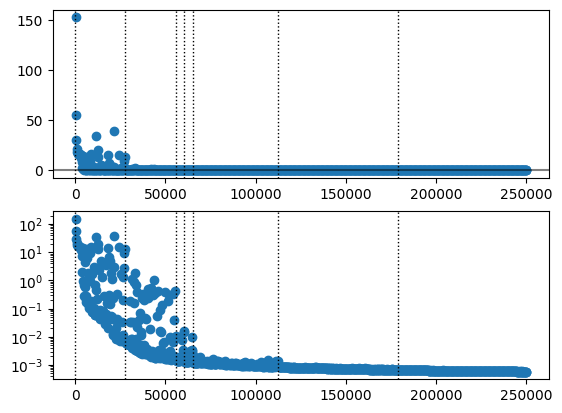

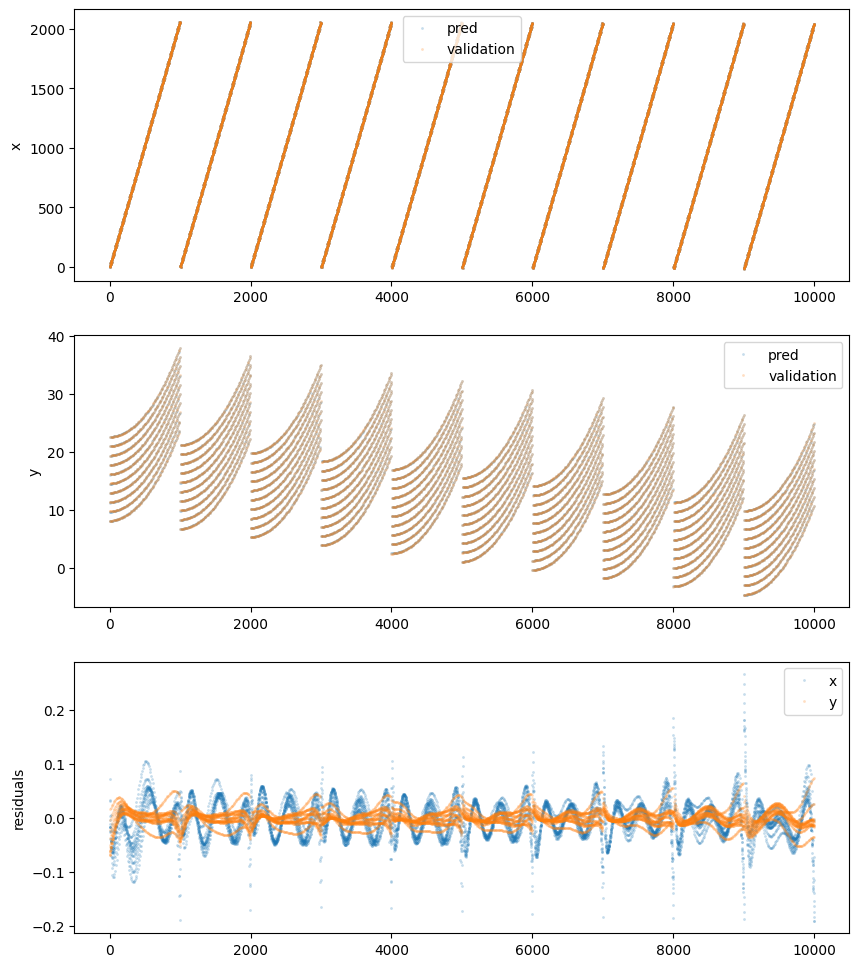

In [147]:
%%time

inscale = [(float(valid_ins[...,i].min()), float(valid_ins[...,i].max())) for i in range(valid_ins.shape[-1])]
outscale = [(float(valid_outs[...,i].min()), float(valid_outs[...,i].max())) for i in range(valid_outs.shape[-1])]
res = batch_train_resample(RescalingNeuralNetwork(inscale, outscale, nneurons=[64,32,16,16], endsmooth=False), 
                           1024*16, 250000, log_period=250, npregen='valid', perm=False, 
                           optimizer=dict(lr=1e-3, fused=True), 
                           lrsched={'mode':'min', 'patience':10, 'factor':.3, 'threshold':.0001}, verbose='r')
plot_model_run(res)
fig = plot_model_results(res, maxpoints=None, alpha=.25, ms=2)